In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing
import xgboost as xgb

# Preprocessing

In [5]:
data = pd.read_csv('https://bitbucket.org/silverxlibra/music-mental-health/downloads/mxmh_survey_results.csv')

In [6]:
data.shape

(736, 33)

In [7]:
data.head(5)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


In [8]:
data.columns

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Permissions'],
      dtype='object')

In [9]:
data["Music effects"].unique() #labels

array([nan, 'No effect', 'Improve', 'Worsen'], dtype=object)

In [10]:
data.isnull().values.any()

True

## Data Cleaning

Drop NULL or replace?
*   Looks like dropping nulls will suffice. Compared to the amount of data entries, dropping shouldn't be a concern here [except BPM]

Dropping columns?

*   BPM is not a column we are intending to use, so we can drop. (it also has the most nulls)
* Perhaps drop Timestamp as well? Not sure how necessary it is for us.



In [11]:
#See nulls across the dataset
data.isna().sum()

Timestamp                         0
Age                               1
Primary streaming service         1
Hours per day                     0
While working                     3
Instrumentalist                   4
Composer                          1
Fav genre                         0
Exploratory                       0
Foreign languages                 4
BPM                             107
Frequency [Classical]             0
Frequency [Country]               0
Frequency [EDM]                   0
Frequency [Folk]                  0
Frequency [Gospel]                0
Frequency [Hip hop]               0
Frequency [Jazz]                  0
Frequency [K pop]                 0
Frequency [Latin]                 0
Frequency [Lofi]                  0
Frequency [Metal]                 0
Frequency [Pop]                   0
Frequency [R&B]                   0
Frequency [Rap]                   0
Frequency [Rock]                  0
Frequency [Video game music]      0
Anxiety                     

In [12]:
#Drop nulls
clean_data = data.dropna()

In [13]:
len(clean_data)

616

In [14]:
#verify nulls are gone
clean_data.isna().sum()

Timestamp                       0
Age                             0
Primary streaming service       0
Hours per day                   0
While working                   0
Instrumentalist                 0
Composer                        0
Fav genre                       0
Exploratory                     0
Foreign languages               0
BPM                             0
Frequency [Classical]           0
Frequency [Country]             0
Frequency [EDM]                 0
Frequency [Folk]                0
Frequency [Gospel]              0
Frequency [Hip hop]             0
Frequency [Jazz]                0
Frequency [K pop]               0
Frequency [Latin]               0
Frequency [Lofi]                0
Frequency [Metal]               0
Frequency [Pop]                 0
Frequency [R&B]                 0
Frequency [Rap]                 0
Frequency [Rock]                0
Frequency [Video game music]    0
Anxiety                         0
Depression                      0
Insomnia      

In [15]:
#drop unneccsary columns
clean_data = clean_data.drop(columns=['Timestamp', 'Composer','BPM','Permissions'])

In [16]:
#verify columns are dropped
clean_data.head(2)

,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Fav genre,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
2,18.0,Spotify,4.0,No,No,Video game music,No,Yes,Never,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect
3,61.0,YouTube Music,2.5,Yes,No,Jazz,Yes,Yes,Sometimes,Never,...,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve


In [17]:
# Encode our categorical variables into numeric values

encoded_data = pd.DataFrame()

encoder = preprocessing.LabelEncoder()

for column in clean_data.select_dtypes(include='object'):
    encoded_data[column] = encoder.fit_transform(clean_data[column])

encoded_data.head()


,Primary streaming service,While working,Instrumentalist,Fav genre,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Music effects
0,4,0,0,15,0,1,0,0,3,0,...,3,0,2,2,1,0,1,1,3,1
1,5,1,0,6,1,1,2,0,0,1,...,2,3,2,0,2,2,0,0,0,0
2,4,1,0,12,1,0,0,0,1,0,...,3,2,2,0,2,3,3,0,1,0
3,4,1,1,6,1,1,1,2,0,0,...,3,1,3,1,3,3,3,3,0,0
4,5,1,1,15,1,1,2,0,1,2,...,0,1,1,1,1,1,0,0,2,0


In [18]:
encoded_data.max()

Primary streaming service        5
While working                    1
Instrumentalist                  1
Fav genre                       15
Exploratory                      1
Foreign languages                1
Frequency [Classical]            3
Frequency [Country]              3
Frequency [EDM]                  3
Frequency [Folk]                 3
Frequency [Gospel]               3
Frequency [Hip hop]              3
Frequency [Jazz]                 3
Frequency [K pop]                3
Frequency [Latin]                3
Frequency [Lofi]                 3
Frequency [Metal]                3
Frequency [Pop]                  3
Frequency [R&B]                  3
Frequency [Rap]                  3
Frequency [Rock]                 3
Frequency [Video game music]     3
Music effects                    2
dtype: int64

In [19]:
clean_data.head()

,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Fav genre,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
2,18.0,Spotify,4.0,No,No,Video game music,No,Yes,Never,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect
3,61.0,YouTube Music,2.5,Yes,No,Jazz,Yes,Yes,Sometimes,Never,...,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve
4,18.0,Spotify,4.0,Yes,No,R&B,Yes,No,Never,Never,...,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve
5,18.0,Spotify,5.0,Yes,Yes,Jazz,Yes,Yes,Rarely,Sometimes,...,Very frequently,Very frequently,Very frequently,Very frequently,Never,8.0,8.0,7.0,7.0,Improve
6,18.0,YouTube Music,3.0,Yes,Yes,Video game music,Yes,Yes,Sometimes,Never,...,Rarely,Rarely,Never,Never,Sometimes,4.0,8.0,6.0,0.0,Improve


In [20]:
clean_data['Frequency [Pop]'].unique()

array(['Rarely', 'Sometimes', 'Very frequently', 'Never'], dtype=object)

In [21]:
encoded_data['Frequency [Pop]'].unique()

array([1, 2, 3, 0])

In [22]:
print(f'Validate both datasets are consistent post encoder. \nClean dataset: {len(clean_data)} \nEncoded Dataset: {len(encoded_data)}')

Validate both datasets are consistent post encoder. 
Clean dataset: 616 
Encoded Dataset: 616


In [23]:
#looks at max value of each column (i.e. 0-15) to make sure all categorical variables have been accounted for to their numerical counterpart
encoded_data.min(axis=0)

Primary streaming service       0
While working                   0
Instrumentalist                 0
Fav genre                       0
Exploratory                     0
Foreign languages               0
Frequency [Classical]           0
Frequency [Country]             0
Frequency [EDM]                 0
Frequency [Folk]                0
Frequency [Gospel]              0
Frequency [Hip hop]             0
Frequency [Jazz]                0
Frequency [K pop]               0
Frequency [Latin]               0
Frequency [Lofi]                0
Frequency [Metal]               0
Frequency [Pop]                 0
Frequency [R&B]                 0
Frequency [Rap]                 0
Frequency [Rock]                0
Frequency [Video game music]    0
Music effects                   0
dtype: int64

In [24]:
#one hot encoding for music genre columns
data = pd.get_dummies(data, columns = ['Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]',
                                       'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]',
                                       'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]',
                                       'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]',
                                       'Frequency [R&B]', 'Frequency [Rock]', 'Frequency [Video game music]'])

Docs For Recomender System Reference:
* YT Video: https://www.youtube.com/watch?v=G4MBc40rQ2k
* Geeksforgeeks(high level w/ implementation): https://www.geeksforgeeks.org/recommendation-system-in-python/
* Movie rec system: https://thecleverprogrammer.com/2020/05/20/data-science-project-movie-recommendation-system/
* high lvl implementation: https://365datascience.com/tutorials/how-to-build-recommendation-system-in-python/


# Multi-Class Classifier

*The following recommender system combines the previous two. It uses the predictions from each models as features for a new model that predicts the favorite genre. This new model considers both the age and the mental health conditions.*

In [25]:
encoded_data["Music effects"].unique()

array([1, 0, 2])

In [26]:
clean_data["Music effects"].unique()

array(['No effect', 'Improve', 'Worsen'], dtype=object)

1. Use SelectKBest with the ANOVA F-value scoring function to select the top K features that are most relevant to predicting the target variable.
2. Train a Decision Tree Classifier using the selected features and evaluate its performance.

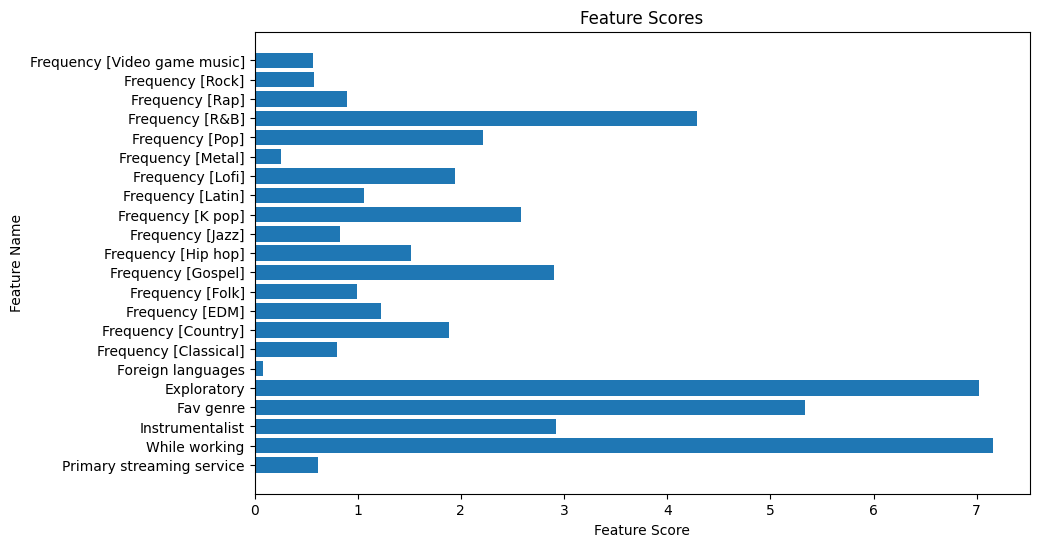

Selected Features: Index(['While working', 'Fav genre', 'Exploratory'], dtype='object')


In [27]:
#combine models into new model
X = encoded_data.drop('Music effects', axis = 1) #all other features
y = encoded_data['Music effects'] #target variable

#feat selection using SelectKBest w/ ANOVA F-value
selector = SelectKBest(score_func = f_classif, k = 3) #select top 3 features
X_selected = selector.fit_transform(X, y)

#get feat scores
feat_scores = selector.scores_
#get feat names
feat_names = X.columns
#bar plot to visualize feat scores
plt.figure(figsize=(10, 6))
plt.barh(feat_names, feat_scores)
plt.xlabel('Feature Score')
plt.ylabel('Feature Name')
plt.title('Feature Scores')
plt.show()

#get indices of selected feats
selected_indices = selector.get_support(indices=True)
#get names of selected feats
selected_feats = X.columns[selected_indices]
print("Selected Features:", selected_feats)

The following is a random classifier without pulling out the best features for X.

In [28]:
#split selected feats, target variable into train/test sets
X_train_basic, X_test_basic, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#initialize decision tree classifier
clf_basic = DecisionTreeClassifier()

#fit classifier to training data
clf_basic.fit(X_train_basic, y_train)

#predict labels of the test set
y_pred = clf_basic.predict(X_test_basic)

#evaluate classifier
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Print classification report
print(classification_report(y_test, y_pred, zero_division = 'warn'))

Accuracy: 0.6693548387096774
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        95
           1       0.31      0.30      0.30        27
           2       0.00      0.00      0.00         2

    accuracy                           0.67       124
   macro avg       0.37      0.36      0.37       124
weighted avg       0.68      0.67      0.67       124



The following is a random classifier using the best features we identified through feature engineering. We can see that the overall accuracy has improved by 10%.

In [29]:
#split selected feats, target variable into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

#initialize decision tree classifier
clf = DecisionTreeClassifier()

#fit classifier to training data
clf.fit(X_train, y_train)

#predict labels of the test set
y_pred = clf.predict(X_test)

#evaluate classifier
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Print classification report
print(classification_report(y_test, y_pred, zero_division = 'warn'))

Accuracy: 0.7419354838709677
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        95
           1       0.20      0.04      0.06        27
           2       0.00      0.00      0.00         2

    accuracy                           0.74       124
   macro avg       0.32      0.33      0.30       124
weighted avg       0.63      0.74      0.67       124



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


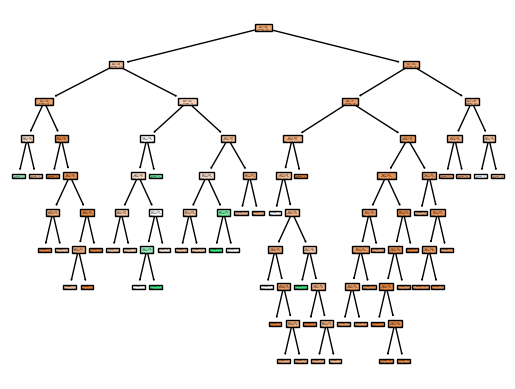

In [30]:
#show decision tree
plot_tree(clf, filled=True)
plt.show()

The following is an attempt to enhance the accuracy further through XGBoost. We see that the accuracy has rounded out to a whole point.  

In [31]:
#XGBoost
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate XGBoost classifier
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", acc_xgb)

# Print classification report for XGBoost
print(classification_report(y_test, y_pred_xgb, zero_division='warn'))

XGBoost Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.77      0.96      0.85        95
           1       0.33      0.07      0.12        27
           2       0.00      0.00      0.00         2

    accuracy                           0.75       124
   macro avg       0.37      0.34      0.33       124
weighted avg       0.66      0.75      0.68       124



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


While visualizing trees may be helpful in random forest so you can see the path taken in making decisions, for XGBoost that is an ensemble model, visualizing individual trees is not necessarily practical or helpful in understanding how the model makes predictions. Instead, its more insightful to analyze the feature importances provided by XGBoost.

Feature ranking:
1. feature 1 (While working): 0.362927
2. feature 0 (Primary streaming service): 0.328007
3. feature 2 (Instrumentalist): 0.309066


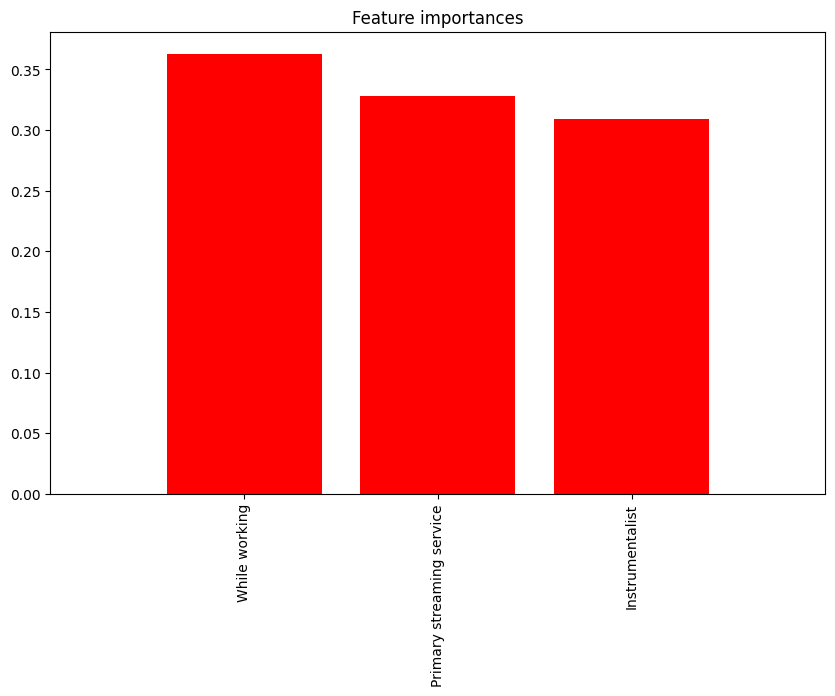

In [36]:
#show feature importances
importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%s): %f" % (f + 1, indices[f], feat_names[indices[f]], importances[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), feat_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()